In [40]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

In [41]:
class Grid3DEnv(gym.Env):
    def __init__(self, grid_size, start, goal, obstacles, R):
        super(Grid3DEnv, self).__init__()
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.state = start
        self.R = R  # 设置前进半径

        self.movements = self.generate_movements()
        self.action_space = spaces.Discrete(len(self.movements))
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(3,), dtype=np.int32)
        self.prev_action = None
        self.movement_cost=0
        self.safety_risk=0
        self.num=0

    def generate_movements(self):
        movements = []
        for dx in range(-self.R, self.R + 1):
            for dy in range(-self.R, self.R + 1):
                for dz in range(-self.R, self.R + 1):
                    if dx == 0 and dy == 0 and dz == 0:
                        continue
                    movements.append(np.array([dx, dy, dz]))
        return movements

    def reset(self):
        self.state = self.start
        self.prev_action = None
        self.safety_risk=0
        self.movement_cost=0
        self.num=0
        return np.array(self.state, dtype=np.int32)

    def step(self, action):
        next_state = self.state + self.movements[action]
        next_state = np.clip(next_state, [0, 0, 0], self.grid_size - 1)
        if np.array_equal(self.state, next_state):
            obe_choose=10
        else:
            obe_choose=0
            
        if self.prev_action is None:
            movement_cost = 1
        else:
            if not np.array_equal(self.movements[self.prev_action], self.movements[action]):
                movement_cost = 2  # 较高的转弯成本
            else:
                movement_cost = 0.5  # 较低的直线移动成本

        relevant_obstacles = [obs for obs in self.obstacles if np.linalg.norm(self.state - obs) <= 3 * self.R]
        safety_risk = sum([np.exp(-np.linalg.norm(next_state - np.array(obstacle))) for obstacle in relevant_obstacles])*10
        self.state = next_state
        done = np.array_equal(self.state, self.goal)
        reward = 3000 if done else - movement_cost - safety_risk - obe_choose

        self.prev_action = action
        if tuple(next_state) in self.obstacles:
            reward = -2000
        self.safety_risk+=safety_risk
        self.movement_cost+=movement_cost
        self.num+=1
        return np.array(self.state, dtype=np.int32), reward, done, {}

    def render(self, mode='human', path=None,filename='result_q1'):
        # Create figure and 3d axis
        fig = plt.figure(figsize=(8, 6))  # 设置画布大小
        ax = fig.add_subplot(111, projection='3d')
        ax.set_facecolor('whitesmoke')  # 设置背景颜色

        # Set limits and labels
        ax.set_xlim([0, self.grid_size[0]-1])
        ax.set_ylim([0, self.grid_size[1]-1])
        ax.set_zlim([0, self.grid_size[2]-1])
        ax.set_xlabel('X-axis', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y-axis', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z-axis', fontsize=12, fontweight='bold')
        ax.set_title('3D Grid Environment Visualization', fontsize=16, fontweight='bold')

        # Plot obstacles
        if self.obstacles:
            obs_x, obs_y, obs_z = zip(*self.obstacles)
            ax.scatter(obs_x, obs_y, obs_z, c='darkred', marker='^', s=150, label='Obstacles', edgecolors='black')

        # Plot start and goal
        ax.scatter(*self.start, c='limegreen', marker='o', s=150, label='Start', edgecolors='black')
        ax.scatter(*self.goal, c='navy', marker='*', s=150, label='Goal', edgecolors='black')

        # Plot path if available
        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], path[:, 2], 'grey', marker='o', markersize=8, linewidth=2, label='Path')

        # Grid, legend, and show
        ax.grid(True)  # 开启网格
        ax.legend(loc='upper left', fontsize='medium', frameon=True, facecolor='white', framealpha=0.8)
        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        plt.show()

In [42]:
class Qnet3D(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Qnet3D, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.f =torch.nn.Softmax()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return x

In [43]:
class DQNAgent3D:
    def __init__(self, input_dim, hidden_dim, output_dim, lr, gamma, epsilon, target_update, device):
        self.action_dim = output_dim
        self.q_net = Qnet3D(input_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet3D(input_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.count = 0

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [44]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)


def train_dqn(env, agent, replay_buffer, num_episodes, minimal_size, batch_size):
    return_list = []
    saft_list=[]
    move_cost_list=[]
    time_list=[]
    for i in range(epochs):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                num = 0
                while not done and num < 1000:
                    num += 1
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                saft_list.append(env.safety_risk)
                move_cost_list.append(env.movement_cost)
                time_list.append(env.num)
                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list,saft_list,move_cost_list,time_list


def visualize_agent_path(env, agent):
    state = env.reset()
    path = [state.copy()]
    done = False
    while not done:
        action = agent.take_action(state)
        state, _, done, _ = env.step(action)
        path.append(state.copy())
    env.render(path=path)

In [45]:
# Hyperparameters
lr = 2e-3
num_episodes = 500
hidden_dim = 64
gamma = 0.98
epsilon = 0.1
target_update = 5
buffer_size = 10000
minimal_size = 500
batch_size = 128
epochs = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [46]:
# Environment parameters
grid_size = np.array([10, 10, 10])
start = np.array([0, 0, 0])
goal = np.array([9, 9, 9])
obstacles = {(i, j, 3) for i in range(0, 5) for j in range(0, 10)}
R = 1  # 设置前进半径

env = Grid3DEnv(grid_size, start, goal, obstacles, R)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = 3  # State is represented by 3D coordinates
action_dim = len(env.movements)  # 动作数取决于前进半径R

agent = DQNAgent3D(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

In [ ]:
return_list,saft_list,move_cost_list,time_list = train_dqn(env, agent, replay_buffer, num_episodes, minimal_size, batch_size)

Iteration 7:  66%|██████▌   | 33/50 [00:39<00:55,  3.29s/it, episode=380, return=-22890.825]

In [39]:
torch.save(agent.q_net.state_dict(),"q1.pth")

In [ ]:
agent.q_net.load_state_dict(torch.load("q1.pth"))

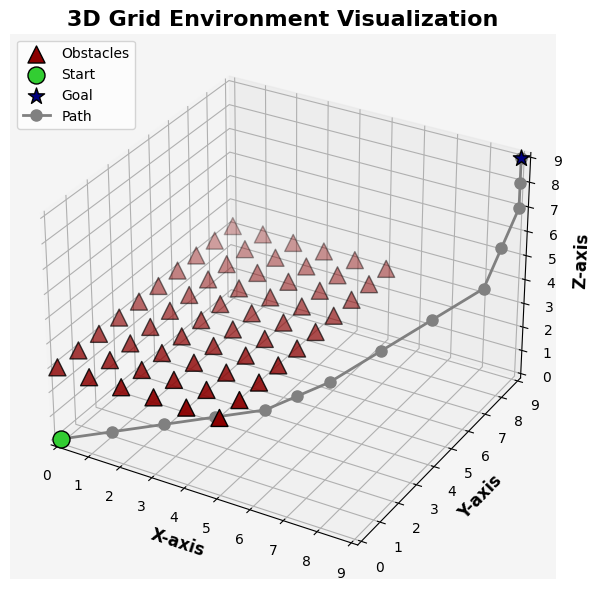

In [46]:
# Visualize the agent's path
visualize_agent_path(env, agent)

In [3]:
def plot_performance(time_list, energy_list, safety_list):
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Time
    ax1.plot(time_list, color='blue', label='Time per Step')
    ax1.set_title('Time Taken Per Step')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Time')
    ax1.grid(True)
    ax1.legend()

    # Plot Energy Consumption
    ax2.plot(energy_list, color='green', label='Energy per Step')
    ax2.set_title('Energy Consumption Per Step')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Energy')
    ax2.grid(True)
    ax2.legend()

    # Plot Safety Metric
    ax3.plot(safety_list, color='red', label='Safety Metric per Step')
    ax3.set_title('Safety Metric Per Step')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Safety Metric')
    ax3.grid(True)
    ax3.legend()

    # Show plot
    plt.tight_layout()
    plt.show()